In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
from datetime import datetime, timedelta
import re
import seaborn as sns
from textblob import TextBlob

### 1. Функции обработки датасета

In [96]:
#функция замены ценовой категории на цифру
def replace_price_tag(tag):
    return price_dict[tag]

#функция заменяет NaN-значения в количестве отзыов на 0 или один (оптимизировать,)
def nan_review_attribution(df, na_col, rev_col):    
    gen = (i for i in df[na_col].index if np.isnan(df[na_col][i]))
    for i in gen:
        df.at[i, na_col] = len(re.findall(r"\d+\/\d+\/\d+", df[rev_col][i]))
    return df[na_col]


#функция возвращает список дат (тип datetime) последних отзывов
def review_dates(lst):
    date_list =[]
    if len(lst):
        for date in lst:
            date_list.append(pd.to_datetime(date))
        return date_list
    else:
        return None
    
#возвращает количество стилей кухни
def cuisine_number(string):
    if pd.isnull(string):
        return 3
    else:
        return len(re.findall(r"\'[\w+\s*]+\'",str(string)))
    
#возвращает время в днях между последними двумя отзывами
def date_delta(lst):
    if lst:
        return abs(lst[0]-lst[-1]).days
    else:
        return 0

def city_resto_num(city):
    return resto_per_city[city]

### 2. Открываем датасет

In [97]:
df = pd.read_csv('main_task_new.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


#### 2.1 Предобработка датасета

In [98]:
df.columns = ['id','city','style','city_rank','rating','price','num_of_reviews','reviews','url_ta','id_ta']

In [99]:
#cities = df.city.value_counts()
#cities.to_excel('Cities.xls')

In [100]:
#заменяем нан в количестве отзывов на ноль или 1
#df['Number_of_Reviews_isNAN'] = pd.isna(df['num_of_reviews']).astype('uint8')
df['num_of_reviews'] = nan_review_attribution(df, 'num_of_reviews','reviews')

#### заменяем текстовую ценовую категорию на числовую

In [101]:
print(df.price.value_counts())
df.price.fillna('$$ - $$$',inplace=True)

$$ - $$$    18412
$            6279
$$$$         1423
Name: price, dtype: int64


In [102]:
#ранжируем ценовую категорию, нан заменяем на самый частый случай (потом можно еще будет подумать. 
# Вообще можно будет ее получить из города типа кухни и другиз факторов через модель)
df.price.unique()

array(['$$ - $$$', '$$$$', '$'], dtype=object)

In [103]:
price_dict = {'$':1, '$$ - $$$':2, '$$$$':3}

In [104]:

df.price = df.price.apply(replace_price_tag)

In [105]:
df.price

0        2
1        2
2        3
3        2
4        2
        ..
39995    2
39996    2
39997    2
39998    2
39999    2
Name: price, Length: 40000, dtype: int64

#### Работаем со стилями кухни. Разбиваем на массив и создаем колонку с количеством представленных кухонь. NaN заменяем на среднее

In [106]:
df['num_of_cuisines'] = df['style'].apply(cuisine_number) 

### работаем с датами

In [10]:
def change_reviews(data, df_columns):
    """ Функция принимает на вход ДФ и колонку с отзывами.
    Создаёт новые колонки в ДФ:
    Review_1 - c текстом первого отзыва;
    Review_2 - с текстом второго отзыва;
    How_long_ago_1 - сколько дней назад написан первый отзыв;
    How_long_ago_2 - сколько дней назад написан второй отзыв;
    Day1_2 - разница в днях написания первого и второго отзыва;
    Day_of_week_1 - день недели написания первого отзыва;
    Day_of_week_2 - день недели написания второго отзыва;
    Month_1 - месяц написания первого отзыва;
    Month_2 - месяц написания второго отзыва"""
    df_columns.fillna('[[], []]', inplace=True)
    data['Two_reviews'] = df_columns.apply(lambda x: x.split('],')[0].split("',"))
    # Создаёт две колонки с текстами отзывов
    data['Review_1'] = data['Two_reviews'].apply(lambda x: x[0])
    data['Review_2'] = data['Two_reviews'].apply(lambda x: x[-1])
    data['Review_1'] = data['Review_1'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace('"', ''))
    data['Review_2'] = data['Review_2'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace('"', ''))
    data.drop('Two_reviews', axis=1, inplace=True)

    # Удалим повторы, если отзыв был один и он продублировался в столбец Review_2
    data['Review_2'] = data[['Review_2', 'Review_1']].apply(
        lambda x: '' if x[0] == x[1] else x[0], axis=1)

    # Работа с датами
    data['Days_reviews'] = df_columns.apply(
        lambda x: x.split('],')[-1].split("',"))
    data['Day_1'] = data['Days_reviews'].apply(lambda x: x[0])
    data['Day_2'] = data['Days_reviews'].apply(lambda x: x[-1])
    data['Day_1'] = data['Day_1'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', ''))
    data['Day_2'] = data['Day_2'].apply(
        lambda x: x.replace('[', '').replace("'", '').replace(']', '').replace(' ', '').replace('"', ''))
    data.drop('Days_reviews', axis=1, inplace=True)

    # Удалим вторую дату (дубликат первой), если отзыв был всего один
    data['Day_2'] = data[['Day_2', 'Review_2']].apply(
        lambda x: '' if x[1] == '' else x[0], axis=1)

    # Переведём данные в формат datetime.strptime для удобства дальнейшей работы
    data['Day_1'] = data['Day_1'].apply(lambda x: x if len(
        x) == 0 else datetime.strptime(x, '%m/%d/%Y'))
    data['Day_2'] = data['Day_2'].apply(lambda x: x if len(
        x) == 0 else datetime.strptime(x, '%m/%d/%Y'))

    # Cоздаём колонки, показывающие сколько дней назад были написаны отзывы
    data['How_long_ago_1'] = (datetime.today() - data['Day_1'])
    data['How_long_ago_2'] = datetime.today() - data['Day_2']
    data['How_long_ago_1'] = data['How_long_ago_1'].apply(lambda x: x.days)
    data['How_long_ago_2'] = data['How_long_ago_2'].apply(lambda x: x.days)
    # Если пропущены значения, то заменим на среднее
    data['How_long_ago_1'].fillna(
        round(data['How_long_ago_1'].mean()), inplace=True)
    data['How_long_ago_2'].fillna(
        round(data['How_long_ago_2'].mean()), inplace=True)

    # Создаём колонку с разницей в датах отзывов
    data['Day1_2'] = abs(data['Day_1'] - data['Day_2'])
    data['Day_1'] = data['Day_1'].fillna(0)
    data['Day_2'] = data['Day_2'].fillna(0)
    data['Day1_2'] = data['Day1_2'].apply(lambda x: x.days)
    data['Day1_2'] = data['Day1_2'].fillna(0)

    # Создаём колонки с днями недели отзывов и месяцы
    data['Day_of_week_1'] = data['Day_1'].apply(
        lambda x: 0 if x == 0 else x.strftime('%A'))
    data['Day_of_week_2'] = data['Day_2'].apply(
        lambda x: 0 if x == 0 else x.strftime('%A'))
    data['Month_1'] = data['Day_1'].apply(
        lambda x: 0 if x == 0 else x.strftime('%m'))
    data['Month_2'] = data['Day_2'].apply(
        lambda x: 0 if x == 0 else x.strftime('%m'))

    # Удаляем больше ненужные колонки
    data.drop('Day_1', axis=1, inplace=True)
    data.drop('Day_2', axis=1, inplace=True)
    data.drop('reviews', axis=1, inplace=True)

In [11]:
change_reviews(df,df['reviews'])

In [12]:
df['Review_1'] = df['Review_1'].apply(lambda x: TextBlob(x).polarity)
df['Review_2'] = df['Review_2'].apply(lambda x: TextBlob(x).polarity)

In [13]:
#df['review_dates'] = df['reviews'].apply(lambda x: re.findall(r"\d+\/\d+\/\d+",x))
#df['review_dates'] = df['review_dates'].apply(review_dates)
#на выходе массив дат в datetime формате

In [14]:


#df['time_delta'] = df['review_dates'].apply(date_delta)


#year = datetime.timedelta(days=365)
#df['review_deltas'] = df['review_dates'].apply(date_delta)
#len(df[df.time_delta > year])

### разделим сити_ранг ресторана на количество ресторанов в данном городе

In [15]:
resto_per_city = df.city.value_counts().to_dict()
#df['n_of_restos'] = 0

#for index, row in df.iterrows():
#    row['n_of_restos'] = resto_per_city[row['city']]


### добавляем данные по ВВП на душу населения

In [16]:
cities = pd.read_excel('Cities.xls')
df = pd.merge(df, cities, on='city')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               40000 non-null  object 
 1   city             40000 non-null  object 
 2   style            30717 non-null  object 
 3   city_rank        40000 non-null  float64
 4   rating           40000 non-null  float64
 5   price            40000 non-null  float64
 6   num_of_reviews   40000 non-null  float64
 7   url_ta           40000 non-null  object 
 8   id_ta            40000 non-null  object 
 9   num_of_cuisines  40000 non-null  int64  
 10  Review_1         40000 non-null  float64
 11  Review_2         40000 non-null  float64
 12  How_long_ago_1   40000 non-null  float64
 13  How_long_ago_2   40000 non-null  float64
 14  Day1_2           40000 non-null  float64
 15  Day_of_week_1    40000 non-null  object 
 16  Day_of_week_2    40000 non-null  object 
 17  Month_1     

### нормируем ранг на количество ресторанов в городе

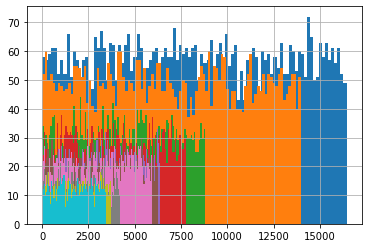

In [17]:
for x in (df['city'].value_counts())[0:10].index:
    df['city_rank'][df['city'] == x].hist(bins=100)
plt.show()

In [18]:

df['num_of_resto'] = df.city.apply(city_resto_num)
df.city_rank = df.city_rank/df.num_of_resto #norm per number of resto in a city
#df.num_of_resto = df.num_of_resto/df.population #per 1000 people
#df.num_of_reviews = df.num_of_reviews/df.population*1000 #per 1 000 000 people
#df.price = df.price/df.gdp*10000 #price range norm per GDP
#df.drop(columns=['city'], inplace=True)

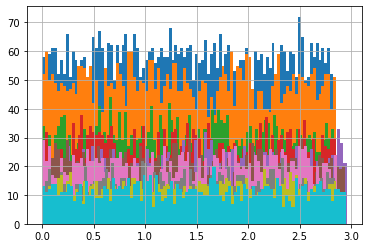

In [19]:
for x in (df['city'].value_counts())[0:10].index:
    df['city_rank'][df['city'] == x].hist(bins=100)
plt.show()

### добавим dummy переменную по городам

In [20]:
#добавим dummy переменную по городам
dummy = pd.get_dummies(df.city)
#df.drop(columns='city', inplace=True)
df = pd.concat([df, dummy], axis=1)


In [21]:
df = df.select_dtypes(exclude='object')

In [22]:
df.to_csv('5&dummies.csv', index=False)

In [23]:
df.sample(5)

,city_rank,rating,price,num_of_reviews,num_of_cuisines,Review_1,Review_2,How_long_ago_1,How_long_ago_2,Day1_2,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
35557,1.354123,5.0,1.0,0.0,6,0.0,0.0,1545.0,1613.0,0.0,...,0,0,0,0,1,0,0,0,0,0
9501,0.113775,4.0,2.5,371.0,4,0.7,0.6,1305.0,1309.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4147,0.512559,4.5,1.0,50.0,2,0.0,0.8,1360.0,1393.0,33.0,...,0,0,0,1,0,0,0,0,0,0
37380,1.710106,4.0,2.5,30.0,0,0.0,0.6,1447.0,1824.0,377.0,...,0,0,0,0,0,0,0,0,0,0
30047,1.941176,4.5,1.0,3.0,1,1.0,0.0,1377.0,2031.0,654.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city_rank        40000 non-null  float64
 1   rating           40000 non-null  float64
 2   price            40000 non-null  float64
 3   num_of_reviews   40000 non-null  float64
 4   num_of_cuisines  40000 non-null  int64  
 5   Review_1         40000 non-null  float64
 6   Review_2         40000 non-null  float64
 7   How_long_ago_1   40000 non-null  float64
 8   How_long_ago_2   40000 non-null  float64
 9   Day1_2           40000 non-null  float64
 10  gdp              40000 non-null  int64  
 11  population       40000 non-null  int64  
 12  num_of_resto     40000 non-null  int64  
 13  Amsterdam        40000 non-null  uint8  
 14  Athens           40000 non-null  uint8  
 15  Barcelona        40000 non-null  uint8  
 16  Berlin           40000 non-null  uint8  
 17  Bratislava  